# Importmos los paquetes

from traceback import print_tb
import pymysql
import datetime
from datetime import date
from datetime import timedelta
import pandas as pd
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import logging
import re

In [1]:
from traceback import print_tb
import pymysql
import datetime
from datetime import date
from datetime import timedelta
import pandas as pd
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import logging
import re
import matplotlib.pyplot as plt
import numpy as np



# Definimos los parametros de la base de datos

In [2]:

host = '35.241.159.127' #este el el host nuevo
user = 'admin'
password = '12345678'
database = 'GET_DATABASE'


connection = pymysql.connect(host=host,
                             user=user,
                             password=password,
                             db=database)

cursor = connection.cursor()

# Cargamos las funciones

In [3]:

def run_query(q):
    with pymysql.connect(host=host,
                             user=user,
                             password=password,
                             db=database) as conn:
        return pd.read_sql(q, conn)

# Humedad

## Extraccion datos humedad de get

In [4]:
q = '''
select * from `GET_DATABASE`.`HUMEDAD` as A
union 
select * From `GET_DATABASE`.`HUMEDAD_prueba`

limit 10;

'''

In [5]:
run_query(q )

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id_humedad,Humedad_relativa,DIA,HORA
0,5,85,2022-03-17,0 days 06:00:00
1,6,85,2022-03-17,0 days 12:00:00
2,7,90,2022-03-17,0 days 18:00:00
3,8,80,2022-03-17,0 days 00:00:00
4,9,85,2022-03-18,0 days 06:00:00
5,10,75,2022-03-18,0 days 12:00:00
6,11,85,2022-03-18,0 days 18:00:00
7,12,80,2022-03-18,0 days 00:00:00
8,13,90,2022-03-19,0 days 06:00:00
9,14,80,2022-03-19,0 days 12:00:00


## Humedad diaria GET

Con esto obtendriamos los datos de las tablas de las humedades. Sin embargo, nosotros queremos, comparar los datos de la humedad de GET, con el historico de AEMET, que viene con una frecuencia **diaria**, por lo que cambiamos la query

In [6]:
q = '''select  DIA, ROUND(avg(Humedad_relativa),2) as humedad_media from (
    select * from `HUMEDAD`

    UNION

    select * from `HUMEDAD_prueba`
    
) as HUMEDAD
GROUP BY DIA;
'''

HUMEDAD_GET = run_query(q )

HUMEDAD_GET.head()

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,DIA,humedad_media
0,2022-03-17,85.00
1,2022-03-18,81.25
2,2022-03-19,86.25
3,2022-03-20,83.75
4,2022-03-21,92.50


Con esto ya podemos empezar a trabajar en POWERBi, por lo que en el source de la información pondremos ese comando de SQL para obtener datos diarios agregados.

## Humedad horaria Media GET

Si queremos comparar los datos de la humedad de GET contra los de TBA, tenemos que tener en cuenta que los datos de TBA vienen en una frecuencia horaria, por lo que, agrupamos los datos de GET en formato de hora para poder compararlos

In [7]:
q = '''select  HORA, ROUND(avg(Humedad_relativa),2) as humedad_media from (
    select * from `HUMEDAD`

    UNION

    select * from `HUMEDAD_prueba`
    
) as HUMEDAD
GROUP BY HORA;
'''

humedad_horaria = run_query(q )

humedad_horaria.HORA = humedad_horaria.HORA.map(lambda x: str(x)).str.extract('(\d+\:\d+\:\d+)')

humedad_horaria.head()

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,HORA,humedad_media
0,00:00:00,78.51
1,06:00:00,81.99
2,12:00:00,56.10
3,18:00:00,57.88
4,00:00:00,63.85


## Datos de TBA

En cuanto a los datos de TBA, tenemos que tener en cuenta que tenemos menos datos de humedad de GET que en TBA, por lo que primero sacamos la fecha mínima de los datos de GET, luego filttramos los datos de TBA por esa fecha, y finalmente, añadimos los datos de la humedad de GET como columna para que los podamos comparar.

In [8]:
q = '''

select  HUMEDAD_RELATIVA,  HORA, FECHA
    from `GET_DATABASE`.`TBA_AGROSENSORS_HISTORIC_TRAINING`

'''

run_query(q)

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,HUMEDAD_RELATIVA,HORA,FECHA
0,69.65,0 days 11:43:51,2021-12-23
1,67.05,0 days 11:53:10,2021-12-23
2,66.37,0 days 12:02:36,2021-12-23
3,66.69,0 days 12:13:31,2021-12-23
4,66.89,0 days 12:22:51,2021-12-23
...,...,...,...
16499,73.69,0 days 20:09:39,2022-05-19
16500,75.45,0 days 20:19:02,2022-05-19
16501,77.70,0 days 20:28:23,2022-05-19
16502,80.29,0 days 20:37:45,2022-05-19


Además los datos vienen agregados por horas, por lo que primero de todo habra que hacer una **agrupacion por dias**: 

In [9]:
q = '''

select  FECHA, 
AVG(HUMEDAD_RELATIVA) HUMEDAD_MEDIA_DIARIA 
from `GET_DATABASE`.`TBA_AGROSENSORS_HISTORIC_TRAINING`
GROUP BY FECHA

'''

run_query(q)

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,FECHA,HUMEDAD_MEDIA_DIARIA
0,2021-12-23,66.704390
1,2021-12-27,35.087292
2,2022-01-03,63.975849
3,2022-01-13,64.167073
4,2022-01-18,87.847498
...,...,...
114,2022-05-15,69.523851
115,2022-05-16,69.658333
116,2022-05-17,71.180470
117,2022-05-18,72.555480


Luego, tal y como deciamos tenemos más registros en TBA que en GET, por lo que para comaprar las oscilaciones de la humedad, tendremos que filtrar los datos de TBA. Tenemos datos de GET desde:

In [10]:


q = '''
select min(DIA) as DIA 
from (

                select * from `HUMEDAD`
                UNION
                select * from `HUMEDAD_prueba`



) as HUMEDAD_GET
    

'''

run_query(q)

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,DIA
0,2022-03-17


Entonces, vamos a filtrar la agregacion anterior:

In [11]:
q = '''

select  FECHA, 
AVG(HUMEDAD_RELATIVA) HUMEDAD_MEDIA_DIARIA 
from `GET_DATABASE`.`TBA_AGROSENSORS_HISTORIC_TRAINING`
where FECHA > 2022-03-17
GROUP BY FECHA



'''

run_query(q)

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,FECHA,HUMEDAD_MEDIA_DIARIA
0,2021-12-23,66.704390
1,2021-12-27,35.087292
2,2022-01-03,63.975849
3,2022-01-13,64.167073
4,2022-01-18,87.847498
...,...,...
114,2022-05-15,69.523851
115,2022-05-16,69.658333
116,2022-05-17,71.180470
117,2022-05-18,72.555480


Esto de una manera dinamica sería: 

In [12]:
q = '''

select  FECHA, 
AVG(HUMEDAD_RELATIVA) HUMEDAD_MEDIA_DIARIA_TBA
from `GET_DATABASE`.`TBA_AGROSENSORS_HISTORIC_TRAINING`
where FECHA >= (

        select min(DIA) as DIA 
        from (

                        select * from `HUMEDAD`
                        UNION
                        select * from `HUMEDAD_prueba`



        ) as HUMEDAD_GET
)
GROUP BY FECHA



'''

HUMEDAD_TBA_DESDE_FECHA_GET_AEMET = run_query(q)

HUMEDAD_TBA_DESDE_FECHA_GET_AEMET.head()

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,FECHA,HUMEDAD_MEDIA_DIARIA_TBA
0,2022-03-17,84.437187
1,2022-03-18,85.321831
2,2022-03-19,89.924389
3,2022-03-20,89.875303
4,2022-03-21,93.330238


Ahora sí que si podriamos compararlos:

## Visualización comparativa de humedad de TBA y GET

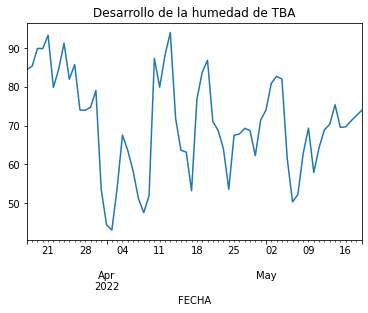

In [13]:
HUMEDAD_TBA_DESDE_FECHA_GET_AEMET = HUMEDAD_TBA_DESDE_FECHA_GET_AEMET.set_index('FECHA')
HUMEDAD_TBA_DESDE_FECHA_GET_AEMET['HUMEDAD_MEDIA_DIARIA_TBA'].plot()
plt.title('Desarrollo de la humedad de TBA')
plt.show()

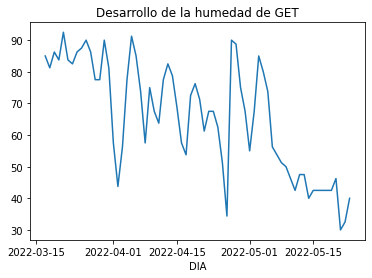

In [14]:
HUMEDAD_GET = HUMEDAD_GET.set_index('DIA')
HUMEDAD_GET['humedad_media'].plot()
plt.title('Desarrollo de la humedad de GET')
plt.show()

## Visualización histograma

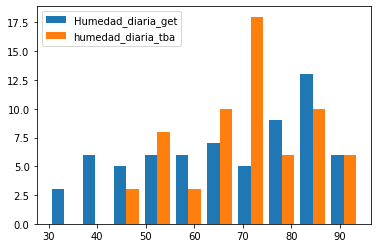

In [15]:


plt.hist([HUMEDAD_GET['humedad_media'],\
          HUMEDAD_TBA_DESDE_FECHA_GET_AEMET['HUMEDAD_MEDIA_DIARIA_TBA']], label=['Humedad_diaria_get', 'humedad_diaria_tba'])
plt.legend(loc='upper left')
plt.show()

## Datos de TBA en función de humedad de GET

Lo suyo para tener los datos de TBA con los datos de GET, sería hacer un left join de GET a TBA desde la fecha mínima de la humedad de GET. 

In [16]:
q = '''

select 

DIA as FECHA, 
HUMEDAD_RELATIVA as HUMEDAD_TBA, 
humedad_media AS HUMEDAD_GET

from (

    select  *
    from `GET_DATABASE`.`TBA_AGROSENSORS_HISTORIC_TRAINING`
    where FECHA >= (
        select min(DIA) as DIA 
        from (

                select * from `HUMEDAD`
                UNION
                select * from `HUMEDAD_prueba`
            ) as TBA_DATA
                    ) 

            ) AS A

LEFT JOIN (

    select  DIA,
    ROUND(avg(Humedad_relativa),2) as humedad_media 
    from (
        select * from `HUMEDAD`
        UNION
        select * from `HUMEDAD_prueba`
    ) as HUMEDAD
    GROUP BY DIA 
    
        ) AS B 

ON A.FECHA = B.DIA
        

'''


#como tenemos fecha y dia, solo nos quedamos con un registro, es decir, el dia

humedad_tba_funcion_get = run_query(q)

#ponemos la fecha en el índice: 
humedad_tba_funcion_get = humedad_tba_funcion_get.set_index('FECHA')

#creamos la media de las dos para ver cuanot puede fluctuar la diferencia

humedad_tba_funcion_get['MEDIA_HUMEDAD_TBA_GET'] = np.mean(humedad_tba_funcion_get, axis = 1)
humedad_tba_funcion_get.head()

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,HUMEDAD_TBA,HUMEDAD_GET,MEDIA_HUMEDAD_TBA_GET
FECHA,,,
2022-03-17,78.77,85.0,81.885
2022-03-17,77.91,85.0,81.455
2022-03-17,78.11,85.0,81.555
2022-03-17,77.73,85.0,81.365
2022-03-17,77.59,85.0,81.295


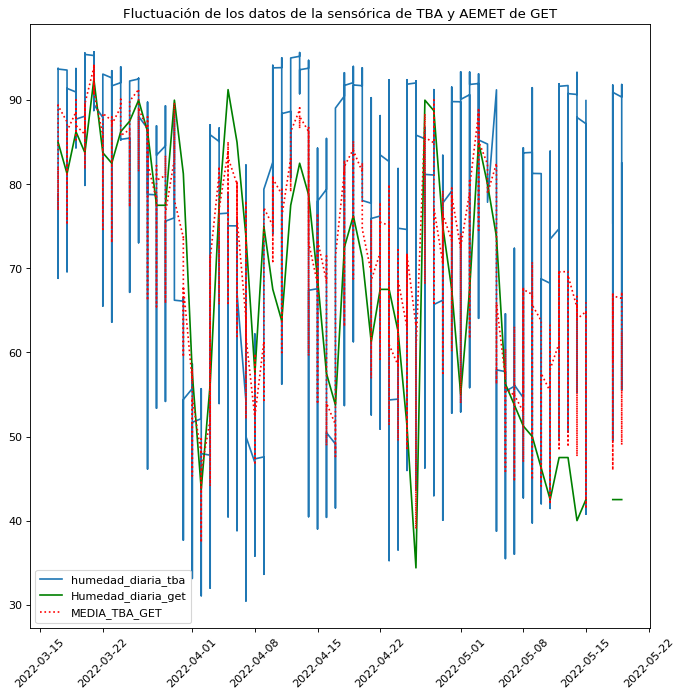

In [17]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plt.plot(humedad_tba_funcion_get['HUMEDAD_TBA'],\
        label = 'humedad_diaria_tba')


plt.plot(humedad_tba_funcion_get['HUMEDAD_GET'],\
         label='Humedad_diaria_get', 
        color = 'green')

plt.plot(humedad_tba_funcion_get['MEDIA_HUMEDAD_TBA_GET'],\
         label = 'MEDIA_TBA_GET', \
         linestyle='dotted', 
        linewidth= 1.5, 
         color = 'red'
        )


plt.legend(loc='lower left')
plt.title('Fluctuación de los datos de la sensórica de TBA y AEMET de GET')
plt.xticks(rotation = 45)
plt.show()

# Sensorica TBA y datos de AEMET (TEMPERATURA MEDIA)

Bien en la sensorica de TBA y en AEMET tenemos datos comunes como la temperatura. Entonces, para poder saber cuanto de exacto puede llegar a ser la temperatura registrada por la sensorica de TBA, vamos a hacer una comparativa entre ambas.

In [25]:
q = '''

select DIA AS FECHA, 

TEMPERATURA_MEDIA AS TEMPERATURA_MEDIA_AEMET, 
temperatura_media_diaria_SENSORICA

from (
    SELECT 
    FECHA as DIA,
    Temperatura_media AS temperatura_media_diaria_SENSORICA
    from 
    DATOS_METEREOLOGIA_HISTORICO_TBA

)AS A

LEFT JOIN (

        SELECT 

        FECHA, 

        AVG(TEMPERATURA) AS TEMPERATURA_MEDIA

        FROM 

        TBA_AGROSENSORS_HISTORIC_TRAINING

        GROUP BY FECHA

) AS B 

ON A.DIA = B.FECHA

where TEMPERATURA_MEDIA != 0

'''

tba_temperatura_media_sen_aemet = run_query(q)

tba_temperatura_media_sen_aemet.head()

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,FECHA,TEMPERATURA_MEDIA_AEMET,temperatura_media_diaria_SENSORICA
0,2021-12-23,16.971707,15
1,2021-12-27,26.858334,19
2,2022-01-03,23.641321,11
3,2022-01-13,26.519025,10
4,2022-01-18,78.412502,9


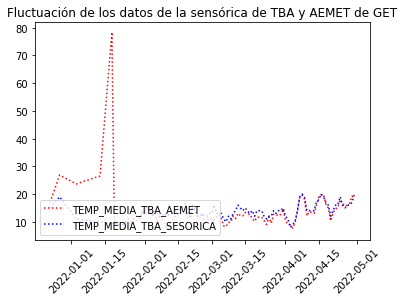

In [26]:
tba_temperatura_media_sen_aemet = tba_temperatura_media_sen_aemet.set_index('FECHA')

plt.plot(tba_temperatura_media_sen_aemet['TEMPERATURA_MEDIA_AEMET'],\
         label = 'TEMP_MEDIA_TBA_AEMET', \
         linestyle='dotted', 
        linewidth= 1.5, 
         color = 'red'
        )

plt.plot(tba_temperatura_media_sen_aemet['temperatura_media_diaria_SENSORICA'],\
         label = 'TEMP_MEDIA_TBA_SESORICA', \
         linestyle='dotted', 
        linewidth= 1.5, 
         color = 'blue'
        )

plt.legend(loc='lower left')
plt.title('Fluctuación de los datos de la sensórica de TBA y AEMET de GET')
plt.xticks(rotation = 45)
plt.show()

Existen outliers, vamos a filtrar los datos en la query otra vez:

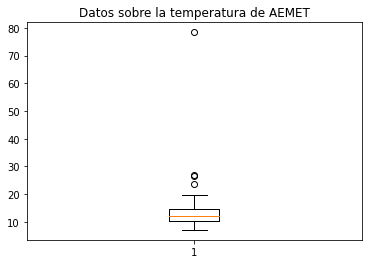

In [27]:
fig1, ax1 = plt.subplots()
ax1.set_title('Datos sobre la temperatura de AEMET')
ax1.boxplot(tba_temperatura_media_sen_aemet['TEMPERATURA_MEDIA_AEMET'])
plt.show()

In [28]:
import numpy as np
np.percentile(tba_temperatura_media_sen_aemet['TEMPERATURA_MEDIA_AEMET'], 75)


14.515827842106093

In [30]:
import math

def calculate_percentile(arry, percentile):
    size = len(arry)
    return sorted(arry)[int(math.ceil((size * percentile) / 100)) - 1]

#Filtramos los datos, clcularemos cual es el percentil 75 para quitar los outliers: 

perecentil_75 = calculate_percentile(tba_temperatura_media_sen_aemet['TEMPERATURA_MEDIA_AEMET'], 75)*1.5


print('\n', 'El cuartil 3º es: ', perecentil_75)


 El cuartil 3º es:  21.77374176315914


Filtramos los datos

C:\Users\kaiet.iglesias_bluet\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


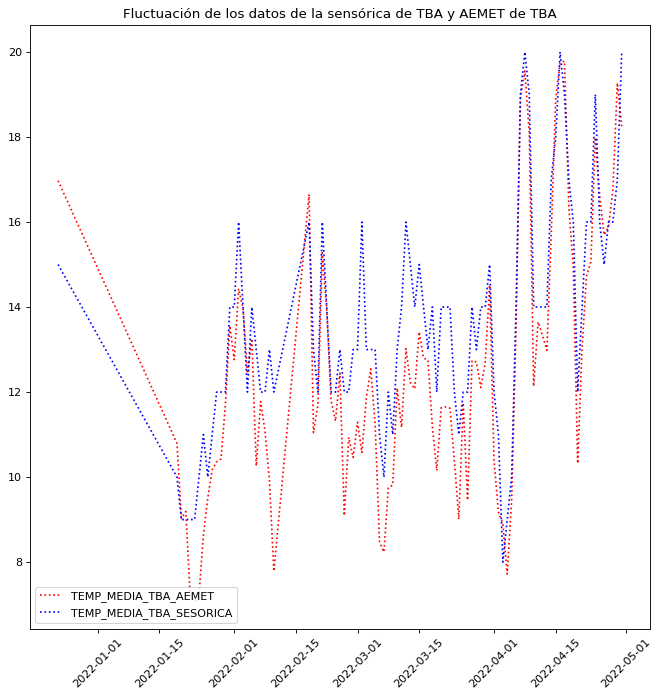

In [32]:


q = '''

select DIA AS FECHA, 

TEMPERATURA_MEDIA AS TEMPERATURA_MEDIA_AEMET, 
temperatura_media_diaria_SENSORICA

from (
    SELECT 
    FECHA as DIA,
    Temperatura_media AS temperatura_media_diaria_SENSORICA
    from 
    DATOS_METEREOLOGIA_HISTORICO_TBA

)AS A

LEFT JOIN (

        SELECT 

        FECHA, 

        AVG(TEMPERATURA) AS TEMPERATURA_MEDIA

        FROM 

        TBA_AGROSENSORS_HISTORIC_TRAINING

        GROUP BY FECHA

) AS B 

ON A.DIA = B.FECHA

where TEMPERATURA_MEDIA != 0 and TEMPERATURA_MEDIA < {}

'''.format(perecentil_75)

tba_temperatura_media_sen_aemet = run_query(q)

tba_temperatura_media_sen_aemet = tba_temperatura_media_sen_aemet.set_index('FECHA')



from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
plt.plot(tba_temperatura_media_sen_aemet['TEMPERATURA_MEDIA_AEMET'],\
         label = 'TEMP_MEDIA_TBA_AEMET', \
         linestyle='dotted', 
        linewidth= 1.5, 
         color = 'red'
        )

plt.plot(tba_temperatura_media_sen_aemet['temperatura_media_diaria_SENSORICA'],\
         label = 'TEMP_MEDIA_TBA_SESORICA', \
         linestyle='dotted', 
        linewidth= 1.5, 
         color = 'blue'
        )

plt.legend(loc='lower left')
plt.title('Fluctuación de los datos de la sensórica de TBA y AEMET de TBA')
plt.xticks(rotation = 45)
plt.show()

**No hay mucha desviacion en los datos, por lo que, se pueden utilizar los datos de la sensorica de TBA como estimadores para el modelo en cuanto a la temperatura media**